<a href="https://colab.research.google.com/github/KavinduJ2001/PR_A03/blob/main/PRA03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = image_segmentation.data.features
y = image_segmentation.data.targets

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)


{'uci_id': 50, 'name': 'Image Segmentation', 'repository_url': 'https://archive.ics.uci.edu/dataset/50/image+segmentation', 'data_url': 'https://archive.ics.uci.edu/static/public/50/data.csv', 'abstract': 'Image data described by high-level numeric-valued attributes, 7 classes', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2310, 'num_features': 19, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C5GP4N', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'The instances were drawn randomly from a database of 7 outdoor images.  The images were handsegmented to create a classification for every pixel.  \r\n\r\n   Each instance is a 3x3 region.', 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_dat

In [4]:
# Display the first few rows of the features and targets
print("\nFirst few rows of features:")
print(X.head())

print("\nFirst few rows of targets:")
print(y.head())



First few rows of features:
   region-centroid-col  region-centroid-row  region-pixel-count  \
0                140.0                125.0                   9   
1                188.0                133.0                   9   
2                105.0                139.0                   9   
3                 34.0                137.0                   9   
4                 39.0                111.0                   9   

   short-line-density-5  short-line-density-2  vedge-mean  vedge-sd  \
0                   0.0                   0.0    0.277778  0.062963   
1                   0.0                   0.0    0.333333  0.266667   
2                   0.0                   0.0    0.277778  0.107407   
3                   0.0                   0.0    0.500000  0.166667   
4                   0.0                   0.0    0.722222  0.374074   

   hedge-mean  hedge-sd  intensity-mean  rawred-mean  rawblue-mean  \
0    0.666667  0.311111        6.185185     7.333334      7.666666   
1

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 126
Validation set size: 42
Testing set size: 42


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.0833 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3026
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.1062 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3026
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.0998 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.1184 - loss: 2.3024 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.1046 - loss: 2.3025 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.1110 - loss: 2.3025 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.1102 - loss: 2.3024 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.0995 - loss: 2.3024 - val_accura

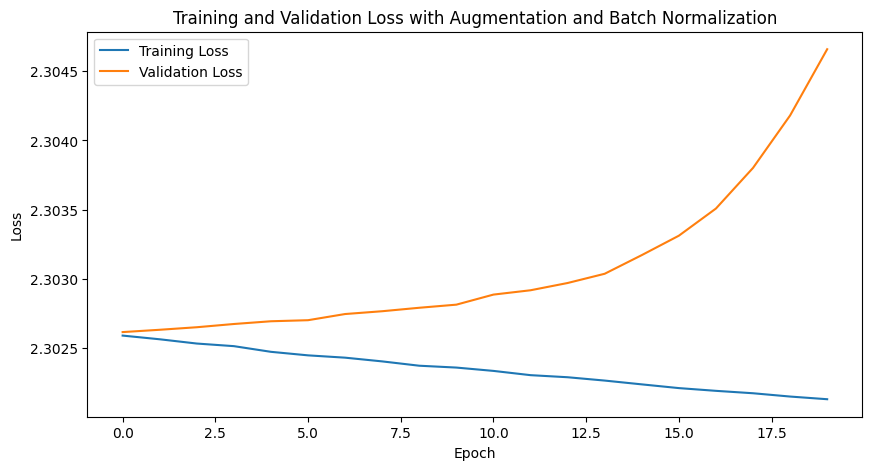

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
x1, m1 = 32, 3  # Filters and kernel size for the first convolutional layer
x2, m2 = 64, 3  # Filters and kernel size for the second convolutional layer
x3, x4 = 128, 64  # Units in fully connected layers
d = 0.5  # Dropout rate
K = 10  # Number of output classes
learning_rate = 0.0001

# Data augmentation for the training data
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotate images up to 20 degrees
    width_shift_range=0.2,     # Shift width by 20% of the image
    height_shift_range=0.2,    # Shift height by 20% of the image
    horizontal_flip=True,      # Flip images horizontally
    brightness_range=[0.8, 1.2], # Adjust brightness
    rescale=1.0 / 255          # Normalize pixel values to [0, 1]
)

# Augment only training data
datagen.fit(X_train)
X_train = X_train / 255.0
X_val = X_val / 255.0

# Build the CNN model with Batch Normalization
model = Sequential([
    Conv2D(filters=x1, kernel_size=(m1, m1), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),  # Add Batch Normalization
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=x2, kernel_size=(m2, m2), activation='relu'),
    BatchNormalization(),  # Add Batch Normalization
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(units=x3, activation='relu'),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(rate=d),

    Dense(units=x4, activation='relu'),  # Additional dense layer for more complexity
    Dropout(rate=d),                     # Dropout to prevent overfitting

    Dense(units=K, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Augmentation and Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
